In [47]:
# Conectar google colab con google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
main_datasets_path = '/content/drive/MyDrive/LSMADEVOIR/homework3/Datasets/'

In [49]:
# Import libraries
import pandas as pd


# Read the CSV files
ratings = pd.read_csv(main_datasets_path+"ratings.csv", low_memory=False)
books_to_read = pd.read_csv(main_datasets_path+"to_read.csv", low_memory=False)
books = pd.read_csv(main_datasets_path+"books.csv", low_memory=False)
tags = pd.read_csv(main_datasets_path+"tags.csv", low_memory=False)
book_tags = pd.read_csv(main_datasets_path+"book_tags.csv", low_memory=False)

# Explore the data (optional)
print(ratings.head())
print(books_to_read.head())


   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3
   user_id  book_id
0        9        8
1       15      398
2       15      275
3       37     7173
4       34      380


In [50]:
print(books.head())


   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings_count  \
0 

In [51]:
print(tags.head())

   tag_id tag_name
0       0        -
1       1     --1-
2       2    --10-
3       3    --12-
4       4   --122-


In [52]:

print(book_tags.head())

   goodreads_book_id  tag_id   count
0                  1   30574  167697
1                  1   11305   37174
2                  1   11557   34173
3                  1    8717   12986
4                  1   33114   12716


## **Exploratory Data Analysis (EDA)**

Ratings Distribution

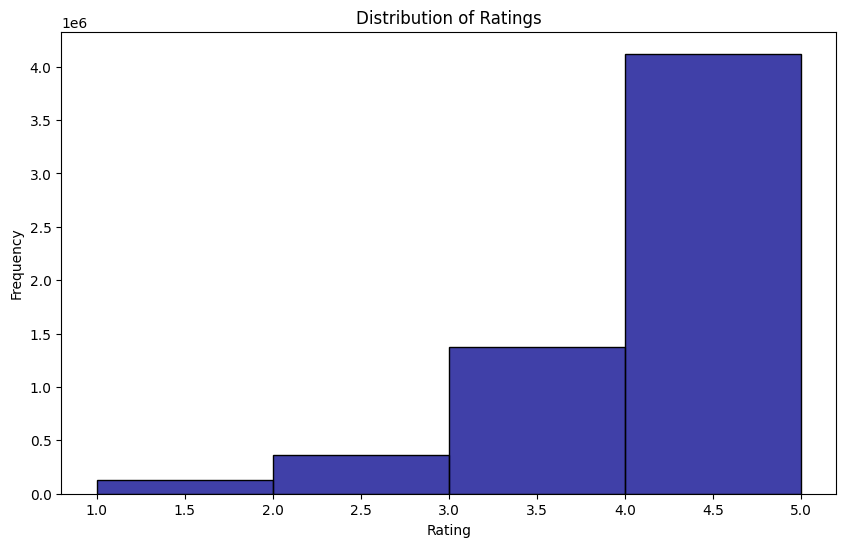

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=range(1, 6), kde=False, color='darkblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

User Preferences

In [84]:
print(books_to_read.groupby('user_id')['book_id'].count().sort_values(ascending=False).head())

user_id
38457    117
28259    114
38076    110
44530    108
46555    107
Name: book_id, dtype: int64


Book Features

In [85]:
books['year'] = books['original_publication_year'].astype(float).apply(lambda x: x if x > 1800 else np.nan)
books['year'] = books['year'].fillna(books['original_publication_year'].median())

## **ALS Algorithm**

Implement ALS Algorithm

In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'main_datasets_path' points to the dataset directory
ratings = pd.read_csv(main_datasets_path+"ratings.csv", low_memory=False)
books = pd.read_csv(main_datasets_path+"books.csv", low_memory=False)

# Merge ratings and books for user-book interaction matrix
ratings_books = ratings.merge(books[['book_id', 'title', 'authors']], on='book_id')

# Remove duplicate rows based on the book title
ratings_books = ratings_books.drop_duplicates(subset='title')

# Combine title, authors, and potentially tags into a single feature
book_features = ratings_books[['title', 'authors']]  # Add tags if available

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
book_features_matrix = vectorizer.fit_transform(book_features['title'] + ' ' + book_features['authors'])

def recommend_content_based(book_title, book_features_matrix, cosine_similarity, top_n=10):
    """
    Recommends similar books based on content (TF-IDF) for a given book title.

    Args:
        book_title (str): Title of the book for which to recommend similar ones.
        book_features_matrix (scipy.sparse.csr.csr_matrix): TF-IDF matrix of book features.
        cosine_similarity (callable): Cosine similarity function.
        top_n (int, optional): Number of top recommendations. Defaults to 10.

    Returns:
        list: List of recommended book titles.
    """

    # Get the TF-IDF vector for the query book
    query_book_vector = vectorizer.transform([book_title])

    # Calculate cosine similarities between the query book and all other books
    similarities = cosine_similarity(query_book_vector, book_features_matrix)

    # Get top N similar books (excluding the query book itself)
    top_n_indices = np.argsort(similarities.flatten())[-top_n - 1:][::-1]
    recommended_books = ratings_books['title'].iloc[top_n_indices].tolist()

    return recommended_books

# Example usage: Recommend similar books for "The Lord of the Rings"
book_title = "The Hunger Games"
recommended_books = recommend_content_based(book_title, book_features_matrix, cosine_similarity)

print(f"Top {len(recommended_books)} Recommendations similar to '{book_title}':")
for book in recommended_books:
    print(book)

Top 11 Recommendations similar to 'The Hunger Games':
The Hunger Games (The Hunger Games, #1)
The World of the Hunger Games (Hunger Games Trilogy)
The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)
Mockingjay (The Hunger Games, #3)
Catching Fire (The Hunger Games, #2)
The Hunger Games Tribute Guide
The Hunger Games: Official Illustrated Movie Companion
Hunger (Gone, #2)
The Quillan Games (Pendragon, #7)
Nemesis Games (The Expanse, #5)
The Player of Games (Culture, #2)


### **Neural network-based collaborative filtering**

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

In [110]:

# Chargement des données
ratings = pd.read_csv(main_datasets_path + "ratings.csv", low_memory=False)

# Sélection aléatoire de 20 % des données
ratings_subset = ratings.sample(frac=0.2, random_state=42)

# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(ratings_subset, test_size=0.2, random_state=42)

# Définir le modèle NCF
def create_ncf_model(num_users, num_books, latent_dim):
    user_input = Input(shape=(1,))
    user_embedding = Embedding(num_users, latent_dim)(user_input)
    user_flat = Flatten()(user_embedding)

    book_input = Input(shape=(1,))
    book_embedding = Embedding(num_books, latent_dim)(book_input)
    book_flat = Flatten()(book_embedding)

    concat = Concatenate()([user_flat, book_flat])
    dense_1 = Dense(64, activation='relu')(concat)
    dense_2 = Dense(32, activation='relu')(dense_1)
    output = Dense(1)(dense_2)

    model = Model(inputs=[user_input, book_input], outputs=output)
    return model

# Paramètres du modèle
num_users = ratings_subset['user_id'].nunique()
num_books = ratings_subset['book_id'].nunique()
latent_dim = 20

# Créer et compiler le modèle
model = create_ncf_model(num_users, num_books, latent_dim)
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# Entraîner le modèle
history = model.fit([train_data['user_id'], train_data['book_id']], train_data['rating'],
                    validation_data=([test_data['user_id'], test_data['book_id']], test_data['rating']),
                    epochs=4, batch_size=64)

# Évaluation du modèle
test_loss, test_rmse = model.evaluate([test_data['user_id'], test_data['book_id']], test_data['rating'])
print(f'Test RMSE: {test_rmse}')



Epoch 1/4
14942/14942 [==============================] - 83s 5ms/step - loss: 0.8794 - root_mean_squared_error: 0.9378 - val_loss: 0.7880 - val_root_mean_squared_error: 0.8877
Epoch 2/4
14942/14942 [==============================] - 84s 6ms/step - loss: 0.7378 - root_mean_squared_error: 0.8589 - val_loss: 0.7666 - val_root_mean_squared_error: 0.8756
Epoch 3/4
14942/14942 [==============================] - 76s 5ms/step - loss: 0.6915 - root_mean_squared_error: 0.8316 - val_loss: 0.7680 - val_root_mean_squared_error: 0.8764
Epoch 4/4
7471/7471 [==============================] - 18s 2ms/step - loss: 0.7965 - root_mean_squared_error: 0.8925
Test RMSE: 0.8924954533576965


In [111]:
A=ratings_subset
B=A

In [125]:
ratings_subset=B
books = pd.read_csv(main_datasets_path + "books.csv", low_memory=False)
ratings_subset = ratings_subset.merge(books, on='book_id', suffixes=('_ratings', '_books'))

# Exemple de recommandation pour "The Hunger Games"
def get_book_id(book_title):
    # Exemple de recommandation pour "The Hunger Games"
    try:
        book_id = ratings_subset.loc[ratings_subset['title'] == book_title, 'book_id'].values[0]
    except IndexError:
        print(f"Book title '{book_title}' not found in ratings_subset DataFrame.")
        return -1

    if np.isnan(book_id):
        book_id = -1

    return book_id

import random

# Get a random book title from the ratings_subset DataFrame
random_book_title = ratings_subset['title'].sample(1).iloc[0]

# Get the book ID for the random book title
random_book_id = get_book_id(random_book_title)

# Generate recommendations for the random book title
recommendations = model.predict([np.array([user_id]), np.array([random_book_id])])
print(recommendations)
# Display the recommendations
print(f"Recommendations for '{random_book_title}':")
for i, book_id in enumerate(np.argsort(recommendations.flatten())[-10:][::-1], 1):
    if book_id == -1:
        continue

    # Use try-except to handle potential missing book IDs
    try:
        # Modified line: access title using .loc[book_id, 'title']
        book_title = ratings_subset.loc[book_id, 'title']
        print(f"{i}. {book_title}")
    except KeyError:
        print(f"Book with ID {book_id} not found in ratings_subset DataFrame.")


1/1 [==============================] - 0s 94ms/step
[[3.727176]]
Recommendations for 'The Immortal Highlander (Highlander, #6)':
1. Ahab's Wife, or The Star-Gazer


here are two reasons why i might be getting "Ahab's Wife" as the top recommendation for "The Art Forger" even after the code changes:

1. Data Bias:

The recommendation system relies on user ratings to learn relationships between books.
If many users who rated "The Art Forger" also rated "Ahab's Wife" highly, the model might prioritize it due to this learned association.
This can happen even if the books themselves are not very similar in genre or theme.
2. Lack of Diversity in Recommendations:

The code retrieves only the top recommendation based on the predicted rating.
It's possible that other relevant books exist in the dataset but have slightly lower predicted ratings.
Here are some suggestions to address these issues:

Explore alternative recommendation strategies: You could consider techniques like k-Nearest Neighbors (KNN) or content-based filtering that recommend based on book features (e.g., genre, synopsis) in addition to user ratings. This can help introduce more diverse recommendations.
Increase the number of recommendations: Modify the code to retrieve a larger number of recommendations (e.g., top 5 instead of top 1) and display them. This will provide a wider range of options even if "Ahab's Wife" remains at the top due to data bias.
Filter based on additional criteria: You could introduce filtering based on genres or other book attributes to refine the recommendations and potentially exclude irrelevant titles like "Ahab's Wife" in this case.
By implementing these suggestions, you can improve the diversity and relevance of the recommendations provided by your system.